# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from nltk.stem.porter import PorterStemmer
from sklearn.naive_bayes import MultinomialNB

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

#filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [20]:
#remove special character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
if not os.path.isfile('preprocessed_reviews.pkl'):   
    # Combining all the above students     
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentence in tqdm(final['Text'].values):
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = decontracted(sentence)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        # https://gist.github.com/sebleier/554280
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
        preprocessed_reviews.append(sentence.strip())
    pickle_out = open('preprocessed_reviews.pkl', 'wb')
    pickle.dump(preprocessed_reviews, pickle_out)
    pickle_out.close()
else:
    pickle_in = open('preprocessed_reviews.pkl', 'rb')
    preprocessed_reviews = pickle.load(pickle_in)

In [23]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similarly you can do preprocessing for review summary also.
# Combining review summaries for all the above students 
if not os.path.isfile('preprocessed_reviews_summary.pkl'):
    preprocessed_reviews_summary = []
    # tqdm is for printing the status bar
    for sentence in tqdm(final['Summary'].values):
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = decontracted(sentence)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        # https://gist.github.com/sebleier/554280
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
        preprocessed_reviews_summary.append(sentence.strip())
    pickle_out = open('preprocessed_reviews_summary.pkl', 'wb')
    pickle.dump(preprocessed_reviews_summary, pickle_out)
    pickle_out.close()
else:
    pickle_in = open('preprocessed_reviews_summary.pkl', 'rb')
    preprocessed_reviews_summary = pickle.load(pickle_in)

In [25]:
preprocessed_reviews_summary[100]

'best dog treat ever'

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:
#BoW
# This part is being skipped for now to avoid data leakage. The BoW model will be later built 
# while performing K-Fold Cross-Validation
'''
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X_train)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
'''

'\ncount_vect = CountVectorizer() #in scikit-learn\ncount_vect.fit(X_train)\nprint("some feature names ", count_vect.get_feature_names()[:10])\nprint(\'=\'*50)\n\nfinal_counts = count_vect.transform(X_train)\nprint("the type of count vectorizer ",type(final_counts))\nprint("the shape of out text BOW vectorizer ",final_counts.get_shape())\nprint("the number of unique words ", final_counts.get_shape()[1])\n'

## [4.2] Bi-Grams and n-Grams.

In [27]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation 
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
#count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# The word encoding is being skipped for now and will be performed later during Cross-Validation 
# stage to avoid data-leakage and to keep the CV and test data unseen by the Classsifer model
'''
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
'''

'\nfinal_bigram_counts = count_vect.fit_transform(X_train)\nprint("the type of count vectorizer ",type(final_bigram_counts))\nprint("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())\nprint("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])\n'

## [4.3] TF-IDF

In [28]:
# The word encoding is being skipped for now and will be performed later during Cross-Validation 
# stage to avoid data-leakage and to keep the CV and test data unseen by the Classsifer model
'''
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
'''

'\ntf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)\ntf_idf_vect.fit(X_train)\nprint("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])\nprint(\'=\'*50)\n\nfinal_tf_idf = tf_idf_vect.transform(X_train)\nprint("the type of count vectorizer ",type(final_tf_idf))\nprint("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())\nprint("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])\n'

# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [29]:
# Please write all the code with proper documentation
# Splitting data into Train and Test Sets
X_train = preprocessed_reviews[:100000]
y_train = final[:100000]['Score']
X_test = preprocessed_reviews[-30000:]
y_test = final[-30000:]['Score']


In [31]:
# Please write all the code with proper documentation
# Splitting data into Train and Test Sets
X_train = preprocessed_reviews[:100000]
y_train = final[:100000]['Score']
X_test = preprocessed_reviews[-30000:]
y_test = final[-30000:]['Score']

# Initializing the BoW(Unigrams and bigrams) Vectorizer with features having min. document-frequency of 10
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn
X_train = np.array(X_train)
y_train = np.array(y_train)
auc_train = []
auc_cv = []

# For alpha values in powers of 10 from -4 to 4
for alpha_i in tqdm(np.logspace(-4, 4, 9)):
    kf = KFold(n_splits=10)
    auc_tr_i = 0; auc_cv_i = 0
    #print("Running 10-fold Cross Validation for alpha :", alpha_i)
    for train_idx, cv_idx in kf.split(X_train):
        #print("LEN of TRAIN:", len(train_idx), "LEN of CV:", len(cv_idx))        
        #Splitting the data into train and CV sets by using the indices generated in each fold of CV
        X_tr = X_train[train_idx]
        X_cv = X_train[cv_idx]
        y_tr = y_train[train_idx]
        y_cv = y_train[cv_idx]
        
        #print(np.shape(X_tr), np(y_tr))
        #print(len(X_cv), len(y_cv))
        
        #Vectorizing the train set
        X_tr = count_vect.fit_transform(X_tr)
        #Featurizing the CV set using the BoW model from train data
        X_cv = count_vect.transform(X_cv)
        
        #Multinomial Naive Bayes Classifier
        clf = MultinomialNB(alpha=alpha_i)
        clf.fit(X_tr, y_tr)
        #Generate AUC scores for Train and CV sets in ith fold 
        auc_tr_i += metrics.roc_auc_score(y_tr, clf.predict_log_proba(X_tr)[:,1])
        auc_cv_i += metrics.roc_auc_score(y_cv, clf.predict_log_proba(X_cv)[:,1])
    
    #Average over 10 folds
    auc_tr_i /= 10.0
    auc_cv_i /= 10.0
    #Add to list of AUCs for each value of alpha
    auc_train.append(auc_tr_i)
    auc_cv.append(auc_cv_i)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [26:49<00:00, 178.50s/it]


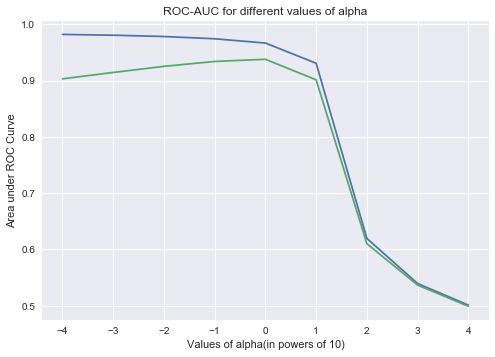

In [32]:
# Plotting the values of AUC for different Hyperparameter values on Train and Cross Validation data
plt.plot(np.arange(-4, 5, 1), auc_train, label='Train AUC')#[4:])
plt.plot(np.arange(-4, 5, 1), auc_cv, label='CV AUC')#[4:])
plt.xlabel('Values of alpha(in powers of 10)')
plt.ylabel('Area under ROC Curve')
plt.title('ROC-AUC for different values of alpha')
plt.grid('on')
#plt.xticks(['10^-4', '10^-3', '10^-2', '10^-1', '1', '10', '10', '100', '1000', '10^4'])
plt.show()

<h4>Observation:</h4><br/> From the plot of AUC values on Train and Cross-Validation data for different values of Hyperparameter alpha, it can be seen that the AUC on CV data is highest and comes closest to the Train AUC value at alpha = 10^0 before both these AUC values begin decreasing. Hence we can consider alpha = 10^0 =1 as the optimal hyperparameter for this classifier and will be using it for classifying the Test Data.

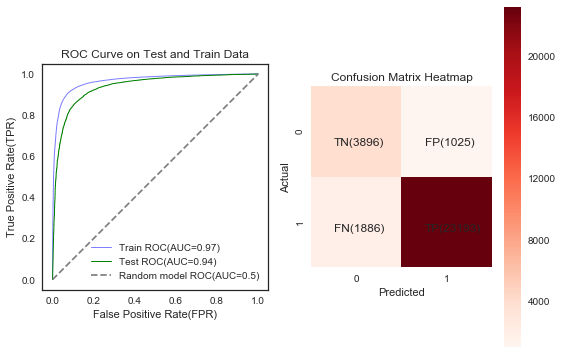

In [33]:
# Running the Classifier with Optimal Hyperparameter on Test Data and plotting the ROCs and confusion matrix
# Resetting values of X_train and X_test to retrain the model with the optimal hyperparameter
X_train = preprocessed_reviews[:100000]
y_train = final[:100000]['Score']
X_test = preprocessed_reviews[-30000:]
y_test = final[-30000:]['Score']
#print(len(X_train), len(y_train))
#print(len(X_test), len(y_test))

# Featurizing the Train and Test Sets
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# Multinomial Naive Bayes Classifier with alpha = 1
clf = MultinomialNB(alpha=1)
clf.fit(X_train,  y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thersholds of 
# log-probabilities of features
# Some code used from below link:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
plt.style.use('seaborn-white')
plt.grid('off')
plt.subplot(1,2,1)
y_train_pred = clf.predict_log_proba(X_train)[:,1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train, y_train_pred)
# Plot ROC for Train Data
plt.plot(fpr_tr, tpr_tr, lw=1, color='blue', 
         label=r'Train ROC(AUC=%.2f)' % (metrics.roc_auc_score(y_train, y_train_pred)), 
         alpha=0.5)

y_pred = clf.predict_log_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# Plot ROC for Test Data
plt.plot(fpr, tpr, lw=1, color='green', label=r'Test ROC(AUC=%.2f)' % (metrics.roc_auc_score(y_test, y_pred)))

# Plot ROC for a Uniform Random Model
plt.plot([0,1], [0,1], '--',color='gray', label='Random model ROC(AUC=0.5)')
plt.legend(loc='lower right', prop={'size':10})
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve on Test and Train Data')
plt.axis('square')
#plt.show()

# Plotting the Confusion matrix as a heatmap
plt.subplot(1,2,2)
tn, fp, fn, tp = confusion_matrix(y_test, clf.predict(X_test)).ravel()
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test)), cmap='Reds')
#print(confusion_matrix(y_test, clf.predict(X_test)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.axis('square')
plt.annotate(r'TN(%d)'%tn, xy=(0.25,1.35))
plt.annotate(r'FP(%d)'%fp, xy=(1.25,1.35))
plt.annotate(r'FN(%d)'%fn, xy=(0.25,0.4))
plt.annotate(r'TP(%d)'%tp, xy=(1.25,0.4))
plt.title('Confusion Matrix Heatmap')
plt.show()

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [34]:
# Please write all the code with proper documentation
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# Sorting indexes of feature log probabilities for +ve class in descending order
pos_class_prob_sorted = -clf.feature_log_prob_[1,:].argsort()
print("Top 10 important features for Positive Class:")
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

Top 10 important features for Positive Class:
['husband not' 'amazon less' 'breaking' 'breakouts' 'breast' 'even use'
 'even vegetarian' 'however great' 'locating' 'additional']


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [35]:
# Please write all the code with proper documentation
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# Sorting indexes of feature log probabilities for +ve class in descending order
neg_class_prob_sorted = -clf.feature_log_prob_[0,:].argsort()
print("Top 10 important features for Negative Class:")
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))

Top 10 important features for Negative Class:
['taste disappointed' 'instead water' 'strong use' 'instead wheat'
 'strong taste' 'strong still' 'strong spicy' 'strong smell'
 'instructions included' 'instructions not']


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [36]:
# Please write all the code with proper documentation
# Splitting data into Train and Test Sets
X_train = preprocessed_reviews[:100000]
y_train = final[:100000]['Score']
X_test = preprocessed_reviews[-30000:]
y_test = final[-30000:]['Score']

# Initializing the TFIDF(Unigrams and bigrams) Vectorizer with features having min.document frequency of 10
count_vect_tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train = np.array(X_train)
y_train = np.array(y_train)
auc_train_tfidf = []
auc_cv_tfidf = []

# For alpha values in powers of 10 from -4 to 4
for alpha_i in tqdm(np.logspace(-4, 4, 9)):
    kf = KFold(n_splits=10)
    auc_tr_i = 0; auc_cv_i = 0
    #print("Running 10-fold Cross Validation for alpha :", alpha_i)
    for train_idx, cv_idx in kf.split(X_train):
        #print("LEN of TRAIN:", len(train_idx), "LEN of CV:", len(cv_idx))        
        #Splitting the data into train and CV sets by using the indices generated in each fold of CV
        X_tr = X_train[train_idx]
        X_cv = X_train[cv_idx]
        y_tr = y_train[train_idx]
        y_cv = y_train[cv_idx]
        
        #print(np.shape(X_tr), np(y_tr))
        #print(len(X_cv), len(y_cv))
        
        #Vectorizing the train set
        X_tr = count_vect_tfidf.fit_transform(X_tr)
        #Featurizing the CV set using the BoW model from train data
        X_cv = count_vect_tfidf.transform(X_cv)
        
        #Multinomial Naive Bayes Classifier
        clf = MultinomialNB(alpha=alpha_i)
        clf.fit(X_tr, y_tr)
        #Generate AUC scores for Train and CV sets in ith fold 
        auc_tr_i += metrics.roc_auc_score(y_tr, clf.predict_log_proba(X_tr)[:,1])
        auc_cv_i += metrics.roc_auc_score(y_cv, clf.predict_log_proba(X_cv)[:,1])
    
    #Average over 10 folds
    auc_tr_i /= 10.0
    auc_cv_i /= 10.0
    #Add to list of AUCs for each value of alpha
    auc_train_tfidf.append(auc_tr_i)
    auc_cv_tfidf.append(auc_cv_i)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [27:57<00:00, 185.52s/it]


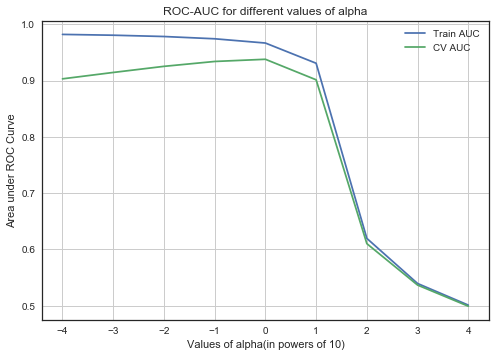

In [37]:
# Plotting the AUC Scores(avg. across 10 fold CV) for different Hyperparameter values on Train and Cross Validation data
plt.plot(np.arange(-4, 5, 1), auc_train, label='Train AUC')
plt.plot(np.arange(-4, 5, 1), auc_cv, label='CV AUC')
plt.xlabel('Values of alpha(in powers of 10)')
plt.ylabel('Area under ROC Curve')
plt.legend(loc='upper right')
plt.title('ROC-AUC for different values of alpha')
#plt.xticks(['10^-4', '10^-3', '10^-2', '10^-1', '1', '10', '10', '100', '1000', '10^4'])
plt.grid('on')
plt.show()

<h4>Observation:</h4><br/> From the plot of AUC values on Train and Cross-Validation data for different values of Hyperparameter alpha, it can be seen that the AUC on CV data is highest and comes closest to the Train AUC value at alpha = 10^0 before both these AUC values begin decreasing. Hence we can consider alpha = 10^0 =1 as the optimal hyperparameter for this classifier and will be using it for classifying the Test Data.

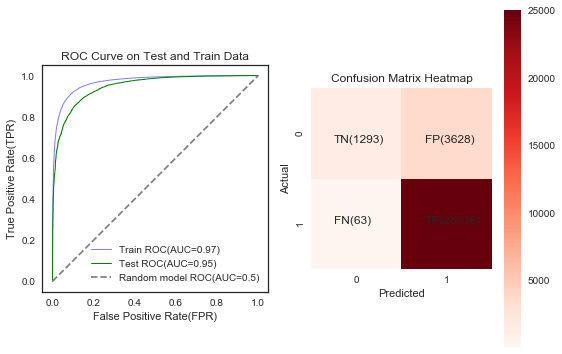

In [46]:
# Running the Classifier with Optimal Hyperparameter on Test Data and plotting the ROCs and confusion matrix
X_train = preprocessed_reviews[:100000]
y_train = final[:100000]['Score']
X_test = preprocessed_reviews[-30000:]
y_test = final[-30000:]['Score']

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# Featurizing the Train and Test Sets
X_train = tf_idf_vect.fit_transform(X_train)
X_test = tf_idf_vect.transform(X_test)

# Multinomial Naive Bayes Classifier with alpha = 10
clf_tfidf = MultinomialNB(alpha=1)
clf_tfidf.fit(X_train,  y_train)

# Plotting the ROC curve on both Train and Test Data
#Some code used from below link:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
plt.style.use('seaborn-white')
plt.grid('off')
plt.subplot(1,2,1)
y_train_pred = clf_tfidf.predict_log_proba(X_train)[:,1]
fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train, y_train_pred)
plt.plot(fpr_tr, tpr_tr, lw=1, color='blue', label=r'Train ROC(AUC=%.2f)' % (metrics.roc_auc_score(y_train, y_train_pred)),
         alpha=0.5)

y_pred = clf_tfidf.predict_log_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, lw=1, color='green', label=r'Test ROC(AUC=%.2f)' % (metrics.roc_auc_score(y_test, y_pred)))

plt.plot([0,1], [0,1], '--', color='gray', label='Random model ROC(AUC=0.5)')
plt.legend(loc='lower right', prop={'size':10})
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC Curve on Test and Train Data')
plt.axis('square')

# Plotting the confusion matrix as a Seaborn heatmap
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, clf_tfidf.predict(X_test)), cmap='Reds')
tn, fp, fn, tp = confusion_matrix(y_test, clf_tfidf.predict(X_test)).ravel()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.axis('square')
plt.annotate(r'TN(%d)'%tn, xy=(0.25,1.4))
plt.annotate(r'FP(%d)'%fp, xy=(1.25,1.4))
plt.annotate(r'FN(%d)'%fn, xy=(0.25,0.5))
plt.annotate(r'TP(%d)'%tp, xy=(1.25,0.5))
plt.title('Confusion Matrix Heatmap')
plt.show()

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [47]:
# Please write all the code with proper documentation
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# Sorting indexes of feature log probabilities for +ve class in descending order

pos_class_prob_sorted = -clf_tfidf.feature_log_prob_[1,:].argsort()
print("Top 10 important features for Positive Class:")
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[:10]))

Top 10 important features for Positive Class:
['breakouts' 'yummm' 'ahead schedule' 'tried regular' 'amazon less'
 'even use' 'even vegetarian' 'locating' 'vacationing' 'fat sugar']


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [48]:
# Please write all the code with proper documentation
# https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes
# Sorting indexes of feature log probabilities for +ve class in descending order

neg_class_prob_sorted = -clf_tfidf.feature_log_prob_[0,:].argsort()
print("Top 10 important features for Negative Class:")
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[:10]))

Top 10 important features for Negative Class:
['tea enjoy' 'tastes' 'hadnt' 'haggis' 'tasteful' 'hair pasta' 'hair skin'
 'hairs' 'tasted terrible' 'half not']


# [6] Conclusions
The results of running the Classifier with their optimal hyperparameters on BOW and TFIDF vectorized test data is summarized belw. Both the BOW and TFIDF featurizations produce similar Test AUC Scores.

In [45]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "Test AUC"]
x.add_row(["BoW", "Multinomial Naive Bayes", "1", "0.94"])
x.add_row(["TF-IDF", "Multinomial Naive Bayes", "1", "0.95"])
print(x)

+------------+-------------------------+----------------+----------+
| Vectorizer |          Model          | Hyperparameter | Test AUC |
+------------+-------------------------+----------------+----------+
|    BoW     | Multinomial Naive Bayes |       1        |   0.94   |
|   TF-IDF   | Multinomial Naive Bayes |       1        |   0.95   |
+------------+-------------------------+----------------+----------+
